In [1]:
import numpy as np
import pandas as pd
import missingno as msn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import math

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# EDA

### Univariate analysis

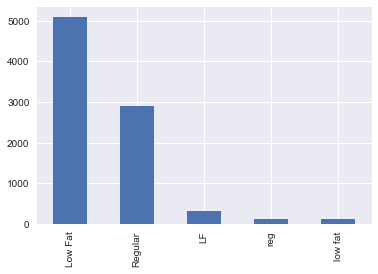

In [3]:
train_data['Item_Fat_Content'].value_counts().plot(kind = 'bar')

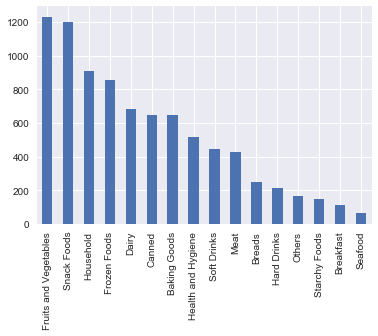

In [4]:
train_data['Item_Type'].value_counts().plot(kind = 'bar')

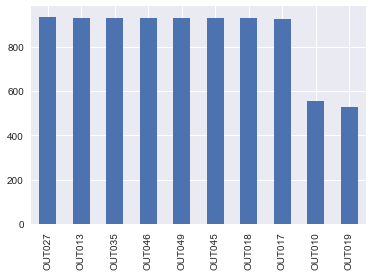

In [5]:
train_data['Outlet_Identifier'].value_counts().plot(kind = 'bar')

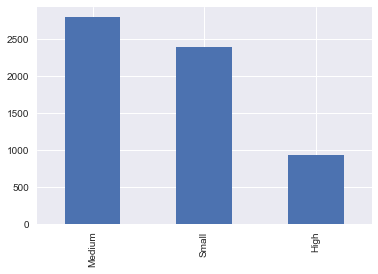

In [6]:
train_data['Outlet_Size'].value_counts().plot(kind = 'bar')

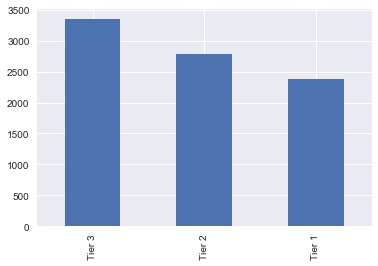

In [7]:
train_data['Outlet_Location_Type'].value_counts().plot(kind = 'bar')

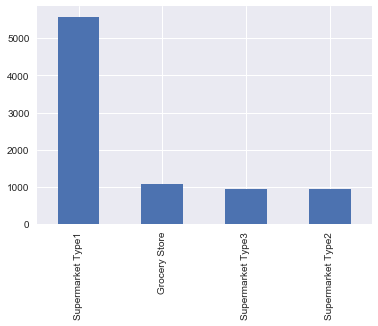

In [8]:
train_data['Outlet_Type'].value_counts().plot(kind = 'bar')

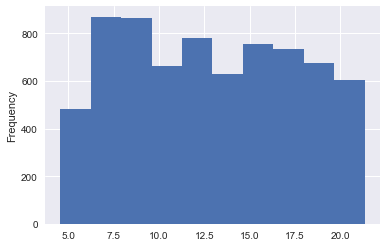

In [9]:
train_data['Item_Weight'].plot(kind = 'hist')

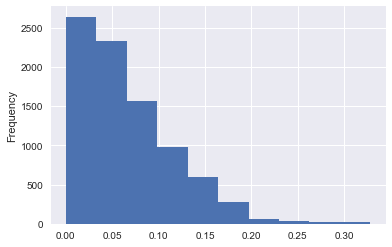

In [10]:
train_data['Item_Visibility'].plot(kind = 'hist')

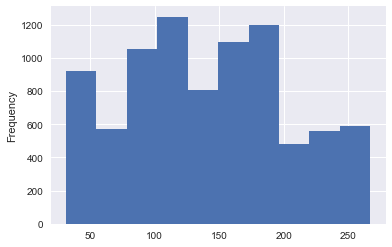

In [11]:
train_data['Item_MRP'].plot(kind = 'hist')

### Bivariate analysis

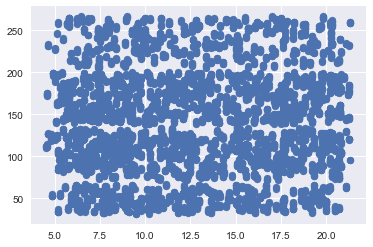

In [12]:
plt.scatter(train_data['Item_Weight'], train_data['Item_MRP'])
plt.show()

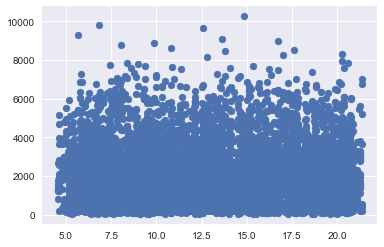

In [13]:
plt.scatter(train_data['Item_Weight'], train_data['Item_Outlet_Sales'])
plt.show()

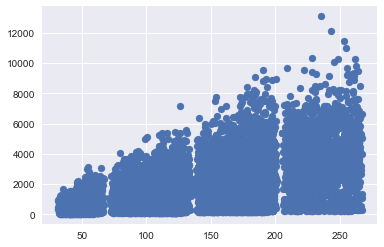

In [14]:
plt.scatter(train_data['Item_MRP'], train_data['Item_Outlet_Sales'])
plt.show()

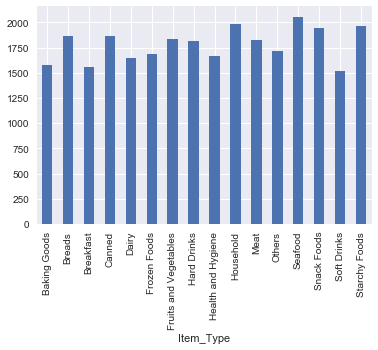

In [15]:
train_data.groupby('Item_Type')['Item_Outlet_Sales'].median().plot(kind = 'bar')

# Feature engineering

### Dealing with catgorical variables:
Using bivariate analysis, we find a relation between the value of our categorical variables and use that information to encode these variables. Doing this instead of one-hot encoding can help us avoid large dimensionality. 

In [16]:
train_data['Item_Fat_Content'].replace(train_data['Item_Fat_Content'].unique(), [2, 1, 2, 2, 1], inplace = True)
test_data['Item_Fat_Content'].replace(test_data['Item_Fat_Content'].unique(), [2, 1, 2, 2, 1], inplace = True)

In [17]:
train_data['Outlet_Size'].replace(['Small', 'Medium', 'High'], [1, 2, 3], inplace = True)
test_data['Outlet_Size'].replace(['Small', 'Medium', 'High'], [1, 2, 3], inplace = True)

In [18]:
train_data['Outlet_Location_Type'].replace(['Tier 1', 'Tier 2', 'Tier 3'], [1, 2, 3], inplace = True)
test_data['Outlet_Location_Type'].replace(['Tier 1', 'Tier 2', 'Tier 3'], [1, 2, 3], inplace = True)

In [19]:
train_data['Outlet_Establishment_Year'] = train_data['Outlet_Establishment_Year'] - train_data['Outlet_Establishment_Year'].median()
test_data['Outlet_Establishment_Year'] = test_data['Outlet_Establishment_Year'] - test_data['Outlet_Establishment_Year'].median()

### Missing values detection

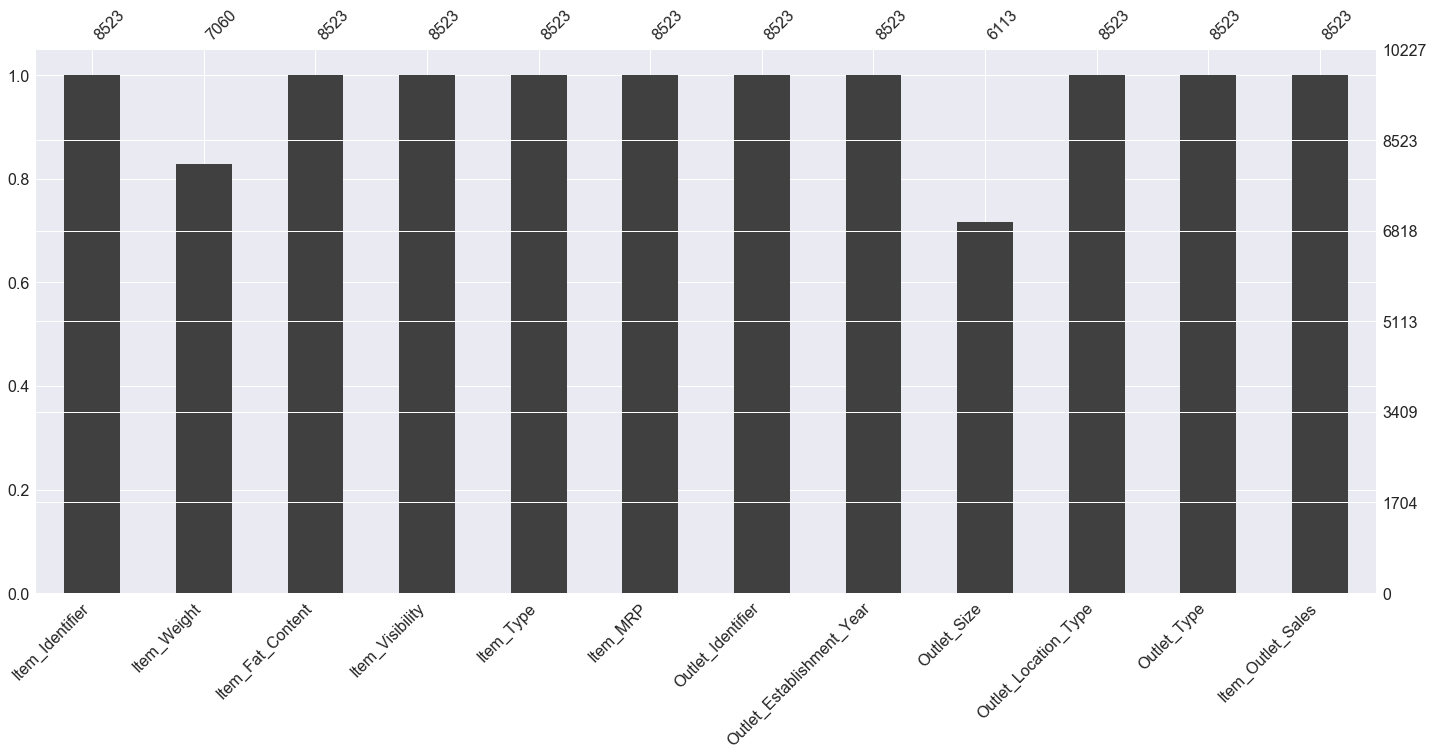

In [20]:
msn.bar(train_data)

### Missing value imputation

In [21]:
train_data['Outlet_Size'] = np.where(train_data['Outlet_Size'].isnull(), 
                                     train_data['Outlet_Size'].mode(), 
                                     train_data['Outlet_Size'])
train_data['Item_Weight'] = np.where(train_data['Item_Weight'].isnull(), 
                                     train_data['Item_Weight'].mean(), 
                                     train_data['Item_Weight'])
test_data['Outlet_Size'] = np.where(test_data['Outlet_Size'].isnull(), 
                                     test_data['Outlet_Size'].mode(), 
                                     test_data['Outlet_Size'])
test_data['Item_Weight'] = np.where(test_data['Item_Weight'].isnull(), 
                                     test_data['Item_Weight'].mean(), 
                                     test_data['Item_Weight'])

In [22]:
train_data.drop(['Item_Identifier', 'Item_Type'], axis = 1, inplace = True)
pred_df = test_data[['Item_Identifier', 'Outlet_Identifier']]
test_data.drop(['Item_Identifier', 'Item_Type'], axis = 1, inplace = True)

In [23]:
train_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,2,0.016047,249.8092,OUT049,0.0,2.0,1,Supermarket Type1,3735.1380
1,5.92,1,0.019278,48.2692,OUT018,10.0,2.0,3,Supermarket Type2,443.4228
2,17.50,2,0.016760,141.6180,OUT049,0.0,2.0,1,Supermarket Type1,2097.2700
3,19.20,1,0.000000,182.0950,OUT010,-1.0,2.0,3,Grocery Store,732.3800
4,8.93,2,0.000000,53.8614,OUT013,-12.0,3.0,3,Supermarket Type1,994.7052


In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,0:9], 
                                                    train_data.iloc[:,9], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [25]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
test_data = pd.get_dummies(test_data)

# Iteration 1: Using ridge regression

In [26]:
clf = Ridge(alpha = 1.0)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

1067.3150709323922

In [27]:
# test_prediction = clf.predict(test_data)
# pred_df['Item_Outlet_Sales'] = test_prediction
# pred_df.to_csv("./bigmart_sales_prediction.csv")

# Iteration 2: Using random forest regressor

In [28]:
clf = RandomForestRegressor(oob_score = True,
                            random_state = 42
                           )

parameters = {'n_estimators': [1000, 1200], 
              'max_features': ['auto', 'sqrt'], 
              'criterion': ['mse'],
              'max_depth': [5], 
              'min_samples_split': [2],
              'min_samples_leaf': [11, 12]
             }
grid_search = GridSearchCV(clf, parameters)
grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

1019.313108079556

In [29]:
# test_prediction = clf.predict(test_data)
# pred_df['Item_Outlet_Sales'] = test_prediction
# pred_df.to_csv("./bigmart_sales_prediction.csv")

In [30]:
grid_search.best_params_ #Helps us to do parameter tuning iteratively

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 12,
 'min_samples_split': 2,
 'n_estimators': 1200}

# Iteration 3: Using Adaboost regressor

In [31]:
dt_rgr = DecisionTreeRegressor(max_depth = 6, max_features = 'auto', min_samples_leaf = 2, random_state = 42)
ada_rgr = AdaBoostRegressor(dt_rgr, loss = 'exponential', n_estimators = 64, learning_rate = 0.05, random_state = 42)
ada_rgr.fit(X_train, y_train)
prediction = ada_rgr.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

1027.2386463470536

In [32]:
# test_prediction = ada_rgr.predict(test_data)
# pred_df['Item_Outlet_Sales'] = test_prediction
# pred_df.to_csv("./bigmart_sales_prediction.csv")

# Iteration 4: Gradient Boosting regressor

In [33]:
ada_rgr = GradientBoostingRegressor(max_depth = 3 ,n_estimators = 3, learning_rate = 1, random_state=42)
ada_rgr.fit(X_train, y_train)
prediction = ada_rgr.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

1043.937646670657